For refrence: https://www.kaggle.com/vetrirah/customer

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from potosnail import *

ml = MachineLearning()
dh = DataHelper()

def Binarize(df, columns_list):
    for col in columns_list:
        booly = list(df[col].apply(lambda x: x==df[col][0], False))
        inty = list(map(int, booly))
        df[col] = inty
    return df

def OHE(series):
    ohe = OneHotEncoder()
    oh = pd.DataFrame(ohe.fit_transform(np.array(series).reshape(-1, 1)).toarray())
    oh.columns = list(np.unique(series))
    return oh

def Cluster2D(data, clusters):
    dh = DataHelper()
    ml = MachineLearning()
    reduced = dh.ScaleData('pca', data, dim=2)
    return ml.ClusterIt(reduced, clusters, quiet=True)

In [2]:
df0 = pd.read_csv('https://raw.githubusercontent.com/spe301/Clustering-Automobile-Customers/main/Train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/spe301/Clustering-Automobile-Customers/main/Test.csv')

In [8]:
test.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...
2622,467954,Male,No,29,No,Healthcare,9.0,Low,4.0,Cat_6
2623,467958,Female,No,35,Yes,Doctor,1.0,Low,1.0,Cat_6
2624,467960,Female,No,53,Yes,Entertainment,NaN,Low,2.0,Cat_6
2625,467961,Male,Yes,47,Yes,Executive,1.0,High,5.0,Cat_4


In [14]:
df = df0.drop(['ID', 'Var_1', 'Segmentation'], axis='columns')
df1 = test.drop(['ID', 'Var_1'], axis='columns')

df2 = pd.concat([df, df1])
df2.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0


In [15]:
df2.shape

(10695, 8)

How I'm going to go about this...

1. get the dataset ready for modeling
2. run a baseline clustering model
3. split the dataframe into multiple dataframes and convert with pd.to_sql() to stimulate a database, in order to brush up on sql
4. Perform EDA
5. Build a better clustering model and save it

# Making gender, martial status, and graduated binary 

In [22]:
df2 = df2.reset_index()

In [23]:
lst = ['Gender', 'Ever_Married', 'Graduated']
Binarize(df2, lst)

,index,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,1,1,22,1,Healthcare,1.0,Low,4.0
1,1,0,0,38,0,Engineer,NaN,Average,3.0
2,2,0,0,67,0,Engineer,1.0,Low,1.0
3,3,1,0,67,0,Lawyer,0.0,High,2.0
4,4,0,0,40,0,Entertainment,NaN,High,6.0
...,...,...,...,...,...,...,...,...,...
10690,2622,1,1,29,1,Healthcare,9.0,Low,4.0
10691,2623,0,1,35,0,Doctor,1.0,Low,1.0
10692,2624,0,1,53,0,Entertainment,NaN,Low,2.0
10693,2625,1,0,47,0,Executive,1.0,High,5.0


# Filling in NaN values

In [28]:
df2['Profession'] = df2['Profession'].fillna('None')

In [29]:
df2['Work_Experience'] = df2['Work_Experience'].fillna(round(np.mean(df2['Work_Experience'])))
df2['Family_Size'] = df2['Family_Size'].fillna(round(np.mean(df2['Family_Size'])))

In [30]:
round(np.mean(df2['Work_Experience']))

3

In [31]:
df2

,index,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,1,1,22,1,Healthcare,1.0,Low,4.0
1,1,0,0,38,0,Engineer,3.0,Average,3.0
2,2,0,0,67,0,Engineer,1.0,Low,1.0
3,3,1,0,67,0,Lawyer,0.0,High,2.0
4,4,0,0,40,0,Entertainment,3.0,High,6.0
...,...,...,...,...,...,...,...,...,...
10690,2622,1,1,29,1,Healthcare,9.0,Low,4.0
10691,2623,0,1,35,0,Doctor,1.0,Low,1.0
10692,2624,0,1,53,0,Entertainment,3.0,Low,2.0
10693,2625,1,0,47,0,Executive,1.0,High,5.0


# Ranking Spending_Score numerically

In [33]:
df2['Spending_Score']

0            Low
1        Average
2            Low
3           High
4           High
          ...   
10690        Low
10691        Low
10692        Low
10693       High
10694        Low
Name: Spending_Score, Length: 10695, dtype: object

In [35]:
ss = df2['Spending_Score']
scores = []
for i in range(len(ss)):
    if ss[i] == 'Low':
        scores.append(1)
    if ss[i] == 'Average':
        scores.append(2)
    if ss[i] == 'High':
        scores.append(3)
        
df2['Spending_Score'] = scores

# One Hot Encoding profession

In [36]:
professions = OHE(df2['Profession'])
df3 = pd.concat([df2.drop(['Profession'], axis='columns'), professions], axis='columns')

# Our first clustering model

In [37]:
df3

,index,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None
0,0,1,1,22,1,1.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,0,38,0,3.0,2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,67,0,1.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0,67,0,0.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0,0,40,0,3.0,3,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10690,2622,1,1,29,1,9.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10691,2623,0,1,35,0,1.0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10692,2624,0,1,53,0,3.0,1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10693,2625,1,0,47,0,1.0,3,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# we use _ clusters because we are segmenting the market into _ categories

def ClusterIt(data, clusters):
    k = KMeans(n_clusters=clusters).fit(data)
    pred = k.predict(data)
    centers = k.cluster_centers_
    X2 = pd.DataFrame(data)
    y = pd.DataFrame(pred)
    y.columns = ['cluster']
    results = pd.concat([X2, y], axis='columns')
    return results
    
ClusterIt(df3, 5)

,index,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None,cluster
0,0,1,1,22,1,1.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,1,0,0,38,0,3.0,2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,0,0,67,0,1.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,1,0,67,0,0.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,4,0,0,40,0,3.0,3,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10690,2622,1,1,29,1,9.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
10691,2623,0,1,35,0,1.0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
10692,2624,0,1,53,0,3.0,1,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
10693,2625,1,0,47,0,1.0,3,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2


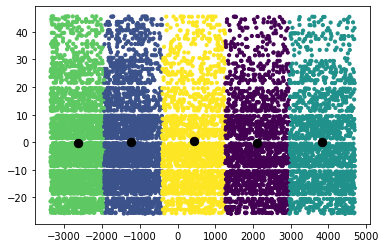

,0,1,cluster
0,-3365.267370,-21.406860,3
1,-3364.266977,-5.424120,3
2,-3363.266314,23.637862,3
3,-3362.266301,23.695841,3
4,-3361.266914,-3.482038,3
...,...,...,...
10690,-743.267175,-14.759744,1
10691,-742.267073,-8.398146,1
10692,-741.266637,9.483959,1
10693,-740.266757,3.544882,1


In [40]:
Cluster2D(df3, 5)